# Neuroimaging full pipeline (MRI, fMRI, diffusion MRI) — teaching notebook

A **full, end-to-end** didactic pipeline emphasizing **NumPy/SciPy transparency** and showing optional calls to common neuroimaging tooling.

Sections:
- Structural MRI (T1w): denoise → bias correction → brain extraction → tissue segmentation → (optional) registration
- fMRI: slice timing (toy) → motion correction (toy) → QC (FD, DVARS) → smoothing → filtering → confounds regression → GLM → connectivity
- dMRI: gradient table → mask from b0 → DTI fit → FA/MD → optional DIPY hooks

## 0) Setup

In [1]:
# Colab installs (uncomment if needed)
# !pip -q install nibabel scipy matplotlib scikit-learn
# Optional:
# !pip -q install antspyx
# !pip -q install dipy

import os, math
import numpy as np
import nibabel as nib
import scipy
import scipy.ndimage as ndi
import scipy.interpolate as spi
import scipy.fft as fft
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.random.seed(0)
print("numpy", np.__version__)
print("scipy", scipy.__version__)
print("nibabel", nib.__version__)

numpy 2.2.6
scipy 1.15.3
nibabel 5.3.2


## 1) Utilities

In [2]:
def show_slices(vol, title="", slice_step=10, cmap="gray", vmax=None):
    z_slices = list(range(0, vol.shape[2], slice_step))
    n = len(z_slices)
    cols = min(6, n)
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, z in enumerate(z_slices):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(vol[:, :, z].T, origin="lower", cmap=cmap, vmax=vmax)
        ax.set_title(f"z={z}")
        ax.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def show_timeseries(ts, title="", xlabel="time", ylabel="value"):
    plt.figure(figsize=(10,3))
    plt.plot(ts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def inspect_nifti(img: nib.Nifti1Image, name="image"):
    print(f"--- {name} ---")
    print("shape:", img.shape)
    print("dtype:", img.get_data_dtype())
    print("affine:\n", img.affine)
    print("voxel sizes:", img.header.get_zooms())

# PART A — Structural MRI (T1w)

## 2) Generate synthetic T1w (bias + noise)

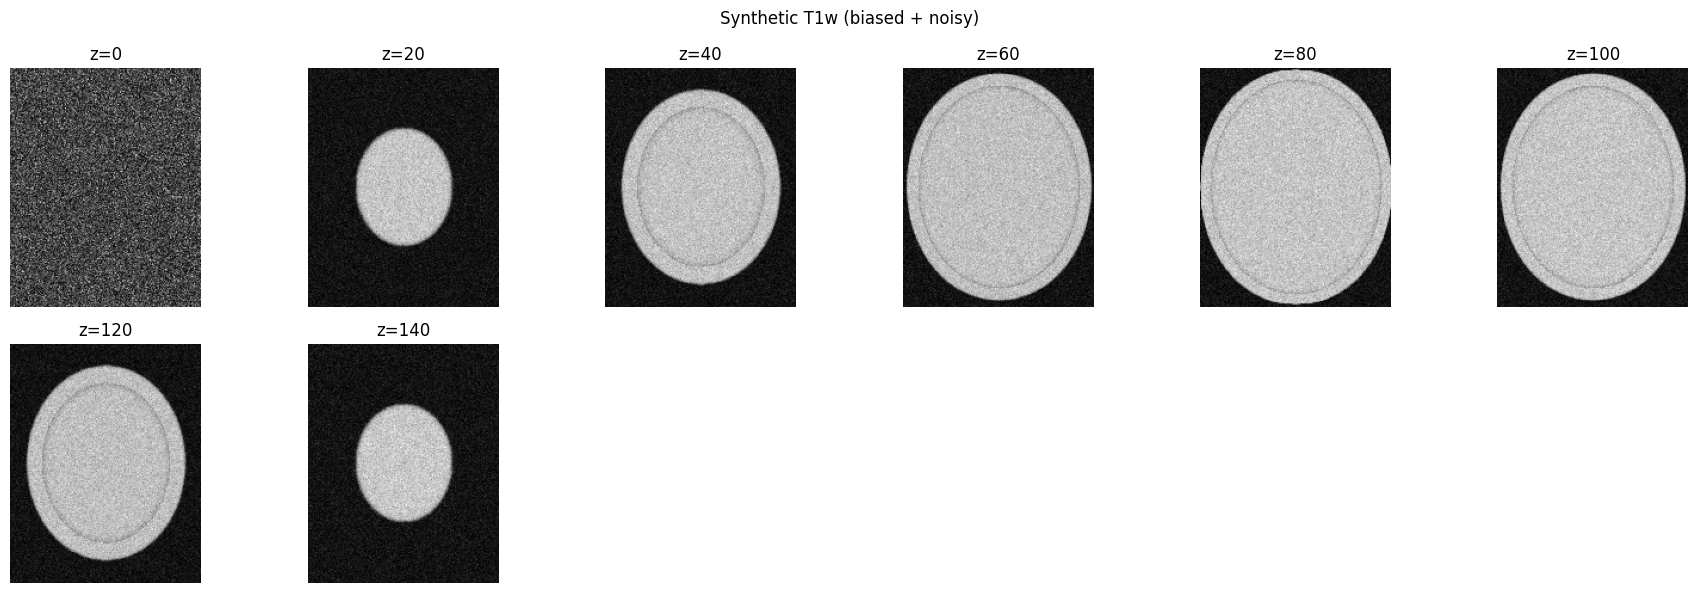

In [ ]:
def smooth_random_field(shape, sigma=6.0):
    return ndi.gaussian_filter(np.random.randn(*shape), sigma=sigma)

def make_brain_mask(shape, radius_fraction=0.45):
    nx, ny, nz = shape
    x = (np.arange(nx) - nx/2) / (nx*radius_fraction)
    y = (np.arange(ny) - ny/2) / (ny*radius_fraction)
    z = (np.arange(nz) - nz/2) / (nz*radius_fraction)
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    mask = (X**2 + Y**2 + (Z*1.2)**2) <= 1.0
    return mask.astype(np.float32)

t1 = nib.load(nib.datasets.get_fnames("anatomical"))
show_slices(t1, "Synthetic T1w (biased + noisy)", slice_step=20)

## 3) Denoising + toy bias correction

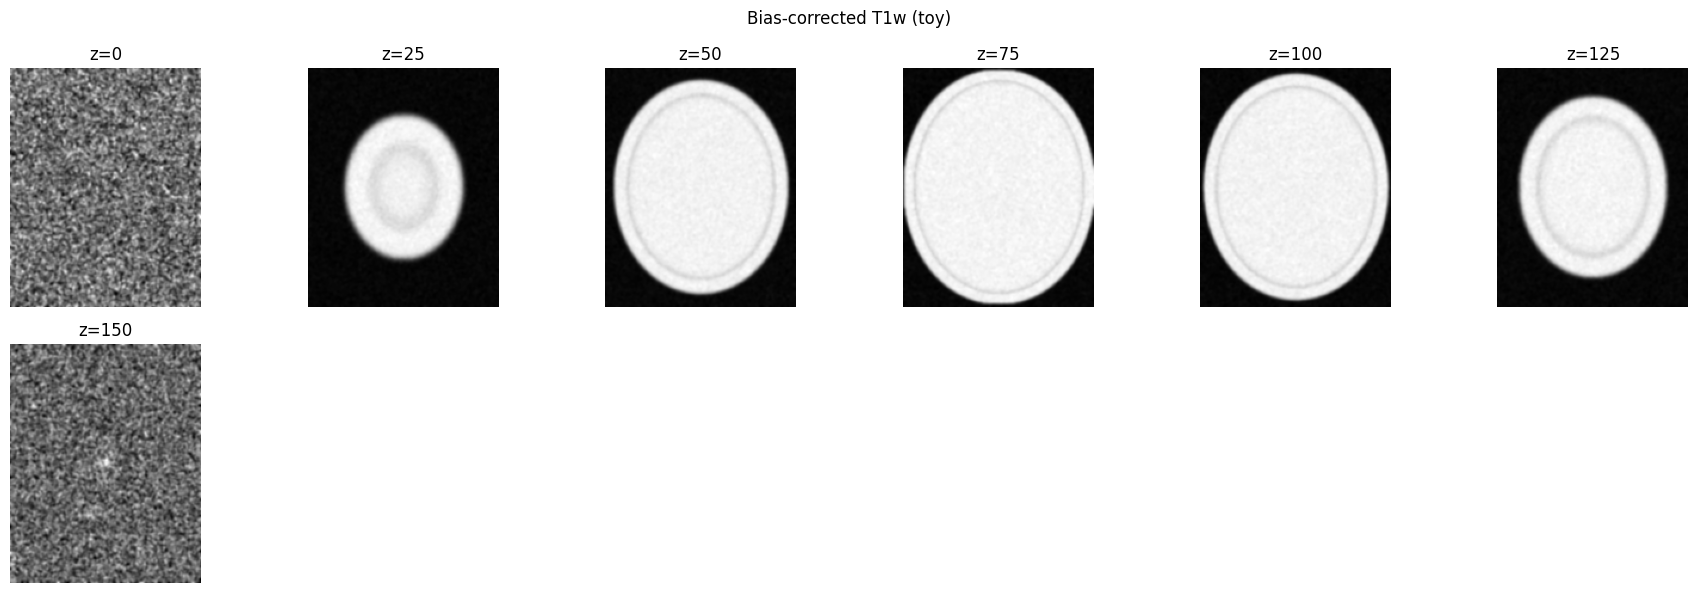

In [4]:
def gaussian_denoise(vol, sigma=1.0):
    return ndi.gaussian_filter(vol, sigma=sigma)

def toy_bias_correct(vol, mask, smooth_sigma=30.0, eps=1e-6):
    v = np.clip(vol, eps, None)
    logv = np.zeros_like(v)
    logv[mask > 0] = np.log(v[mask > 0])
    smooth = ndi.gaussian_filter(logv, smooth_sigma)
    field = np.exp(smooth)
    corrected = vol / np.clip(field, eps, None)
    corrected = corrected / np.percentile(corrected[mask > 0], 99)
    return corrected.astype(np.float32), field.astype(np.float32)

t1_g = gaussian_denoise(t1, sigma=1.0)
t1_corr, bias_est = toy_bias_correct(t1_g, mask=brain_mask_true, smooth_sigma=30)
show_slices(t1_corr, "Bias-corrected T1w (toy)", slice_step=25)

## 4) Brain extraction (toy) + tissue segmentation (didactic 1D GMM)

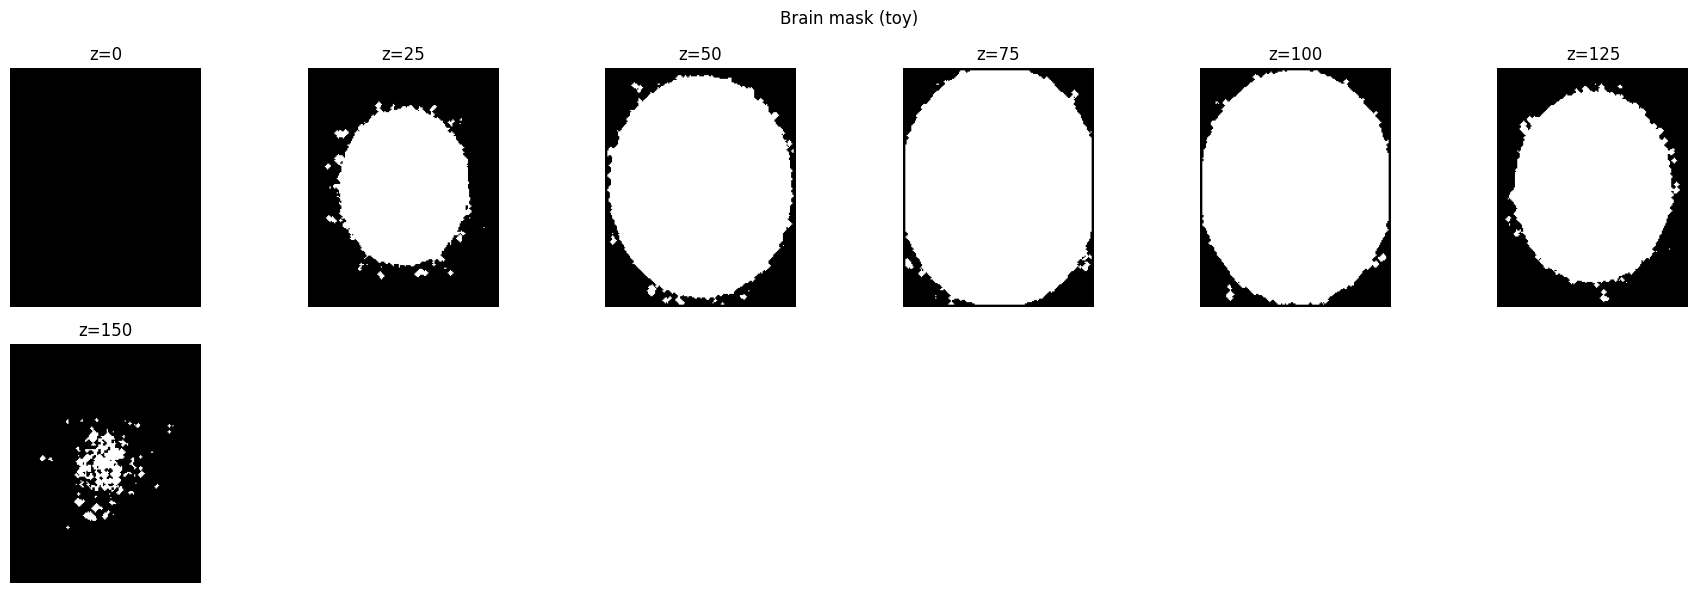

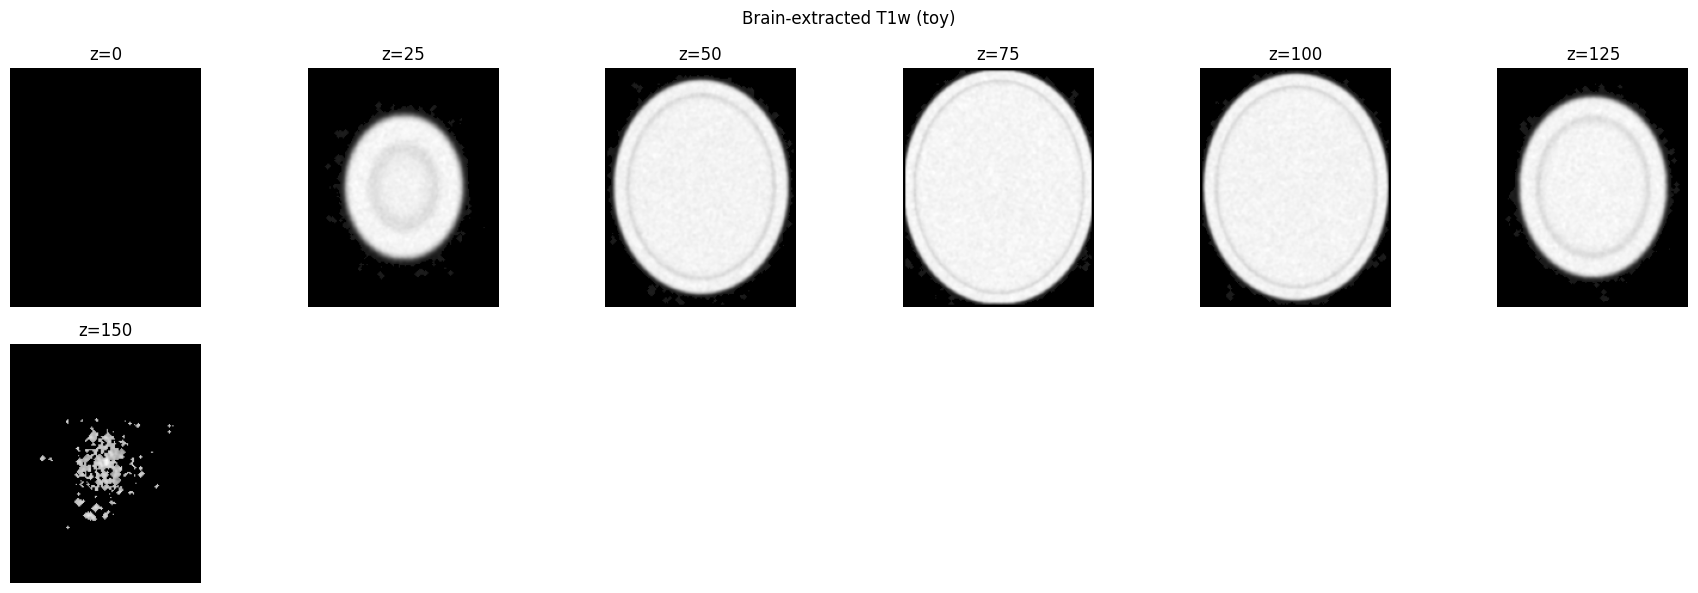

GMM means (low->high): [0.30708626 0.91582896 0.97250531]


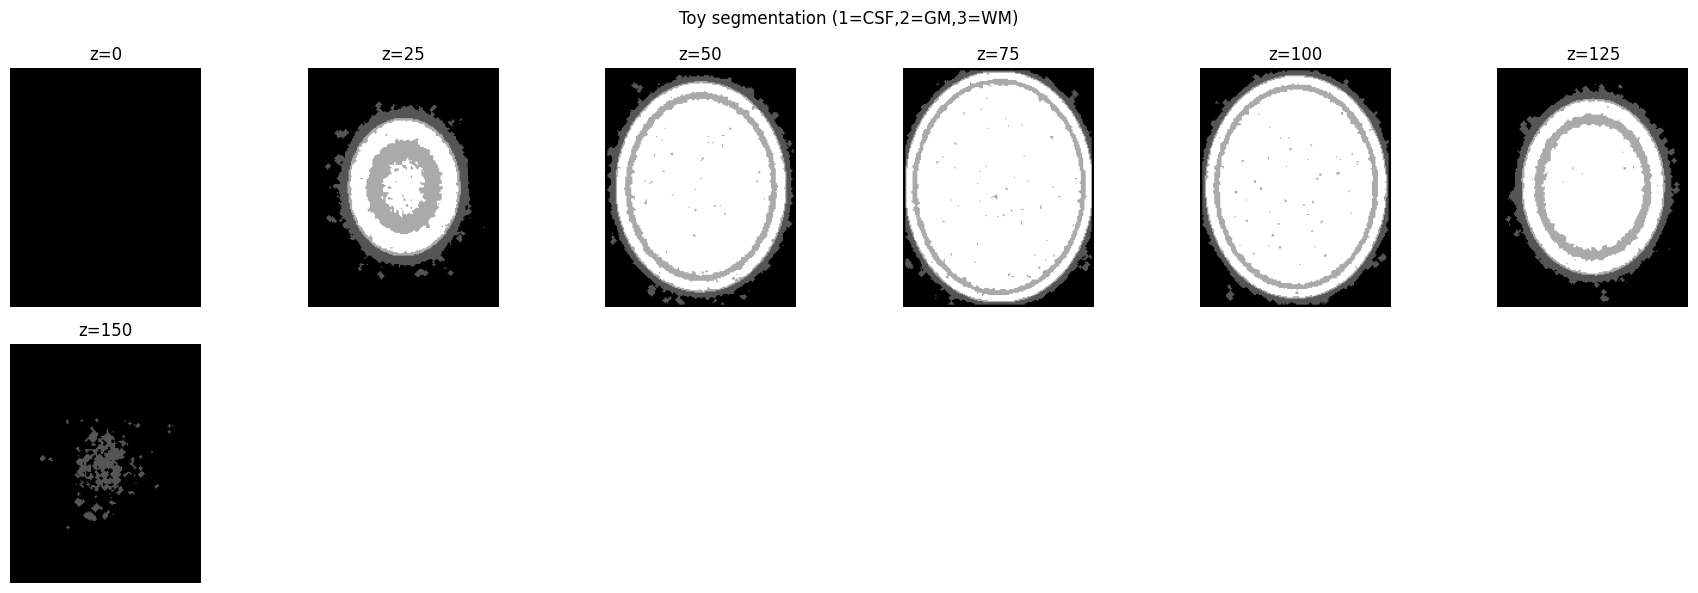

In [5]:
def toy_brain_extract(vol, threshold_quantile=0.30, morph_iters=2):
    thr = np.quantile(vol, threshold_quantile)
    m = (vol > thr)
    m = ndi.binary_opening(m, iterations=morph_iters)
    m = ndi.binary_closing(m, iterations=morph_iters)
    m = ndi.binary_fill_holes(m)
    lbl, n = ndi.label(m)
    if n > 1:
        sizes = ndi.sum(m, lbl, index=np.arange(1, n+1))
        keep = 1 + int(np.argmax(sizes))
        m = (lbl == keep)
    return m.astype(np.uint8)

brain_mask = toy_brain_extract(t1_corr)
t1_brain = t1_corr * brain_mask
show_slices(brain_mask.astype(np.float32), "Brain mask (toy)", slice_step=25, vmax=1)
show_slices(t1_brain, "Brain-extracted T1w (toy)", slice_step=25)

def gmm_1d(x, k=3, n_iter=40, eps=1e-8):
    x = x.astype(float)
    mu = np.quantile(x, np.linspace(0.2, 0.8, k))
    sigma = np.full(k, x.std() + eps)
    pi = np.full(k, 1.0/k)

    def norm_pdf(x, m, s):
        return np.exp(-0.5*((x-m)/s)**2) / (np.sqrt(2*np.pi)*s + eps)

    for _ in range(n_iter):
        resp = np.stack([pi[j]*norm_pdf(x, mu[j], sigma[j]) for j in range(k)], axis=1)
        resp = resp / (resp.sum(axis=1, keepdims=True) + eps)
        Nk = resp.sum(axis=0) + eps
        pi = Nk / x.size
        mu = (resp * x[:, None]).sum(axis=0) / Nk
        var = (resp * (x[:, None] - mu[None, :])**2).sum(axis=0) / Nk
        sigma = np.sqrt(np.maximum(var, eps))

    return pi, mu, sigma

vals = t1_brain[brain_mask > 0].ravel()
pi, mu, sig = gmm_1d(vals, k=3)
order = np.argsort(mu)  # low=CSF, mid=GM, high=WM
pi, mu, sig = pi[order], mu[order], sig[order]
print("GMM means (low->high):", mu)

def gmm_posterior(x, pi, mu, sig, eps=1e-8):
    def norm_pdf(x, m, s):
        return np.exp(-0.5*((x-m)/s)**2) / (np.sqrt(2*np.pi)*s + eps)
    p = np.stack([pi[j]*norm_pdf(x, mu[j], sig[j]) for j in range(len(mu))], axis=0)
    p = p / (p.sum(axis=0, keepdims=True) + eps)
    return p

post = gmm_posterior(vals, pi, mu, sig)  # (3, nvox)
lab = np.argmax(post, axis=0)  # 0..2
seg = np.zeros_like(t1_brain, dtype=np.uint8)
idx = np.where(brain_mask > 0)
seg[idx] = (lab + 1).astype(np.uint8)  # 1=CSF,2=GM,3=WM
show_slices(seg.astype(np.float32), "Toy segmentation (1=CSF,2=GM,3=WM)", slice_step=25, vmax=3)

wm_mask = (seg == 3).astype(np.uint8)
csf_mask = (seg == 1).astype(np.uint8)

## 5) Registration (optional, ANTsPy)

In [ ]:
try:
    import ants
    HAVE_ANTS = True
except Exception as e:
    HAVE_ANTS = False
    print("ANTs not available. Skipping. Error:", str(e)[:200])

if HAVE_ANTS:
    fixed = ants.from_numpy(t1_corr)
    moving_np = ndi.shift(t1_corr, shift=(3, -5, 2), order=1)
    moving = ants.from_numpy(moving_np)
    tx = ants.registration(fixed=fixed, moving=moving, type_of_transform="Rigid")
    moved = tx["warpedmovout"].numpy()
    show_slices(moved, "Rigid-registered moving → fixed (ANTs)", slice_step=25)

# PART B — fMRI pipeline

## 6) Simulate fMRI (task + motion + noise)

In [ ]:
def spm_hrf(tr, length=32.0):
    t = np.arange(0, length, tr)
    def gamma_pdf(t, a, b):
        return (t**(a-1) * np.exp(-t/b)) / (math.gamma(a) * (b**a) + 1e-12)
    h = gamma_pdf(t, 6, 1) - 0.35*gamma_pdf(t, 16, 1)
    return h / (h.max() + 1e-12)

def convolve_hrf(stim, tr):
    return np.convolve(stim, spm_hrf(tr))[:len(stim)]

def simulate_fmri(base_vol, brain_mask, n_tr=180, tr=2.0):
    nx, ny, nz = base_vol.shape
    stim = np.zeros(n_tr)
    for start in [20, 60, 100, 140]:
        stim[start:start+12] = 1.0
    task = convolve_hrf(stim, tr)
    task = (task - task.mean()) / (task.std() + 1e-12)

    X, Y, Z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz), indexing="ij")
    cx, cy, cz = nx*0.55, ny*0.55, nz*0.55
    roi = (((X-cx)/18)**2 + ((Y-cy)/16)**2 + ((Z-cz)/14)**2) < 1.0
    roi = roi & (brain_mask > 0)

    shifts = np.column_stack([
        0.9*np.sin(np.linspace(0, 7*np.pi, n_tr)),
        0.9*np.cos(np.linspace(0, 5*np.pi, n_tr)),
        0.5*np.sin(np.linspace(0, 4*np.pi, n_tr)+0.5),
    ])

    drift = 0.002*np.linspace(-1, 1, n_tr)

    fmri = np.zeros((nx, ny, nz, n_tr), np.float32)
    for t in range(n_tr):
        vol = base_vol * (1 + 0.03*task[t]*roi.astype(np.float32))
        vol = vol * (1 + drift[t])
        vol = vol + 0.03*np.random.randn(nx, ny, nz).astype(np.float32)
        vol = ndi.shift(vol, shift=tuple(shifts[t]), order=1, mode="nearest")
        fmri[..., t] = vol
    return fmri, stim, task, roi.astype(np.uint8), shifts

TR = 2.0
fmri, stim, task, roi, true_shifts = simulate_fmri(t1_corr, brain_mask, n_tr=180, tr=TR)
print("fMRI shape:", fmri.shape)
show_slices(fmri[..., 20], "Example fMRI volume", slice_step=25)

plt.figure(figsize=(10,3))
plt.plot(stim, label="stim")
plt.plot(task, label="stim*HRF")
plt.legend(); plt.title("Design"); plt.tight_layout(); plt.show()

## 7) Slice timing correction (toy, interpolation)

In [ ]:
def slice_timing_correct(fmri_4d, tr, slice_axis=2, interleaved=True, ref_slice=0):
    n_tr = fmri_4d.shape[-1]
    n_slices = fmri_4d.shape[slice_axis]

    if interleaved:
        order = list(range(0, n_slices, 2)) + list(range(1, n_slices, 2))
    else:
        order = list(range(n_slices))

    slice_times = np.zeros(n_slices, float)
    for i, sl in enumerate(order):
        slice_times[sl] = (i / n_slices) * tr

    t_ref = slice_times[ref_slice]
    dt = slice_times - t_ref
    t = np.arange(n_tr) * tr

    out = np.zeros_like(fmri_4d)
    for sl in range(n_slices):
        slicer = [slice(None)] * 4
        slicer[slice_axis] = sl
        slab = fmri_4d[tuple(slicer)]  # (x,y,t)
        slab2 = np.moveaxis(slab, -1, 0)  # (t,x,y)
        T, X, Y = slab2.shape
        slab_flat = slab2.reshape(T, -1)
        t_new = np.clip(t + dt[sl], t[0], t[-1])
        interp = spi.interp1d(t, slab_flat, kind="linear", axis=0, bounds_error=False, fill_value="extrapolate")
        slab_corr = interp(t_new).reshape(T, X, Y)
        slab_corr = np.moveaxis(slab_corr, 0, -1)  # (x,y,t)
        out[tuple(slicer)] = slab_corr.astype(np.float32)
    return out

fmri_stc = slice_timing_correct(fmri, tr=TR, slice_axis=2, interleaved=True, ref_slice=0)

## 8) Motion correction (toy translation via phase correlation)

In [ ]:
def phase_correlation_shift(ref, mov, mask=None, eps=1e-12):
    a = ref.copy()
    b = mov.copy()
    if mask is not None:
        a = a * mask
        b = b * mask
    Fa = fft.fftn(a)
    Fb = fft.fftn(b)
    R = Fa * np.conj(Fb)
    R /= np.maximum(np.abs(R), eps)
    cc = np.real(fft.ifftn(R))
    maxpos = np.unravel_index(np.argmax(cc), cc.shape)
    shifts = np.array(maxpos, dtype=float)
    for i, n in enumerate(cc.shape):
        if shifts[i] > n/2:
            shifts[i] -= n
    return shifts

def motion_correct_4d(fmri_4d, ref_index=0, brain_mask=None):
    ref = fmri_4d[..., ref_index]
    out = np.zeros_like(fmri_4d)
    est = np.zeros((fmri_4d.shape[-1], 3), float)
    for t in range(fmri_4d.shape[-1]):
        s = phase_correlation_shift(ref, fmri_4d[..., t], mask=brain_mask)
        est[t] = s
        out[..., t] = ndi.shift(fmri_4d[..., t], shift=tuple(s), order=1, mode="nearest")
    return out, est

fmri_mc, est_shifts = motion_correct_4d(fmri_stc, ref_index=0, brain_mask=brain_mask)

## 9) QC: FD + DVARS

In [ ]:
def framewise_displacement(translations):
    d = np.vstack([np.zeros((1,3)), np.diff(translations, axis=0)])
    return np.abs(d).sum(axis=1)

def dvars(fmri_4d, mask):
    data = fmri_4d[mask > 0].astype(np.float64)  # (nvox, T)
    diff = np.diff(data, axis=1)
    return np.sqrt((diff**2).mean(axis=0))

fd = framewise_displacement(est_shifts)
dv = dvars(fmri_mc, brain_mask)

show_timeseries(fd, "Framewise Displacement (translations-only, toy)", ylabel="FD (vox)")
show_timeseries(dv, "DVARS (toy)", ylabel="DVARS (a.u.)")

## 10) Smoothing + filtering

In [ ]:
def spatial_smooth_4d(fmri_4d, fwhm_mm=6.0, voxel_size_mm=1.0):
    sigma_mm = fwhm_mm / 2.355
    sigma_vox = sigma_mm / voxel_size_mm
    out = np.zeros_like(fmri_4d)
    for t in range(fmri_4d.shape[-1]):
        out[..., t] = ndi.gaussian_filter(fmri_4d[..., t], sigma=sigma_vox)
    return out

def detrend_timecourse(x):
    t = np.arange(len(x))
    A = np.column_stack([np.ones_like(t), t])
    beta = np.linalg.lstsq(A, x, rcond=None)[0]
    return x - A @ beta

def bandpass_fft(x, tr, low=0.01, high=0.12):
    n = len(x)
    freqs = fft.fftfreq(n, d=tr)
    X = fft.fft(x)
    keep = (np.abs(freqs) >= low) & (np.abs(freqs) <= high)
    return np.real(fft.ifft(X * keep))

def filter_voxels(fmri_4d, mask, tr, low=0.01, high=0.12, max_vox=10000):
    out = np.zeros_like(fmri_4d)
    vox = np.array(np.where(mask > 0)).T
    if vox.shape[0] > max_vox:
        vox = vox[np.random.choice(vox.shape[0], size=max_vox, replace=False)]
        print("Downsampling to", vox.shape[0], "voxels for speed")
    for x,y,z in vox:
        ts = detrend_timecourse(fmri_4d[x,y,z,:])
        ts = bandpass_fft(ts, tr=tr, low=low, high=high)
        out[x,y,z,:] = ts.astype(np.float32)
    return out

fmri_sm = spatial_smooth_4d(fmri_mc, fwhm_mm=6.0, voxel_size_mm=1.0)
fmri_filt = filter_voxels(fmri_sm, brain_mask, tr=TR, low=0.01, high=0.12, max_vox=10000)

## 11) Confounds regression (motion + WM/CSF + trends)

In [ ]:
def extract_mean_ts(fmri_4d, mask):
    v = fmri_4d[mask > 0]
    return v.mean(axis=0)

def regress_confounds(fmri_4d, mask, confounds):
    X = np.column_stack([np.ones(confounds.shape[0]), confounds]).astype(np.float64)
    XtX_inv = np.linalg.inv(X.T @ X)
    P = X @ XtX_inv @ X.T  # (T,T)

    data = fmri_4d[mask > 0].astype(np.float64)  # (nvox, T)
    clean = data - (data @ P.T)
    out = np.zeros_like(fmri_4d)
    out[mask > 0] = clean.astype(np.float32)
    return out

wm_ts  = extract_mean_ts(fmri_sm, wm_mask)
csf_ts = extract_mean_ts(fmri_sm, csf_mask)

mot = est_shifts.astype(np.float64)
mot_d = np.vstack([np.zeros((1,3)), np.diff(mot, axis=0)])

t = np.linspace(-1, 1, fmri_sm.shape[-1])
poly = np.column_stack([t, t**2])

conf = np.column_stack([mot, mot_d, wm_ts, csf_ts, poly])
fmri_clean = regress_confounds(fmri_sm, brain_mask, conf)

## 12) Task GLM (beta + t-map)

In [ ]:
def glm_fit_voxelwise(Y, X):
    XtX_inv = np.linalg.inv(X.T @ X)
    betas = (XtX_inv @ X.T @ Y.T).T
    resid = Y - (betas @ X.T)
    dof = X.shape[0] - X.shape[1]
    sigma2 = (resid**2).sum(axis=1) / max(dof, 1)
    return betas, sigma2, XtX_inv, dof

X = np.column_stack([np.ones_like(task), task, mot, mot_d]).astype(np.float64)
idx = np.where(brain_mask > 0)
Y = fmri_clean[idx[0], idx[1], idx[2], :].astype(np.float64)

betas, sigma2, XtX_inv, dof = glm_fit_voxelwise(Y, X)
se = np.sqrt(sigma2 * XtX_inv[1,1])
tvals = betas[:,1] / (se + 1e-12)

tmap = np.zeros(brain_mask.shape, np.float32)
tmap[idx] = tvals.astype(np.float32)
show_slices(tmap, "Task t-map (toy GLM)", slice_step=25)

## 13) Seed correlation map (resting-style connectivity)

In [ ]:
def seed_correlation_map(fmri_4d, seed_mask, brain_mask):
    seed_ts = fmri_4d[seed_mask > 0].mean(axis=0)
    seed_ts = (seed_ts - seed_ts.mean()) / (seed_ts.std() + 1e-12)

    corr = np.zeros(brain_mask.shape, np.float32)
    idx = np.where(brain_mask > 0)
    for x,y,z in zip(*idx):
        ts = fmri_4d[x,y,z,:]
        ts = (ts - ts.mean()) / (ts.std() + 1e-12)
        corr[x,y,z] = np.dot(seed_ts, ts) / len(ts)
    return corr

seed = ndi.binary_dilation(roi.astype(bool), iterations=1).astype(np.uint8)
corr_map = seed_correlation_map(fmri_clean, seed, brain_mask)
show_slices(corr_map, "Seed correlation map (toy)", slice_step=25)

# PART C — diffusion MRI pipeline

## 14) Simulate DWI (DTI model) + fit FA/MD

In [ ]:
@dataclass
class GradientTable:
    bvals: np.ndarray
    bvecs: np.ndarray

def random_gradients(n, shell_b=1000.0):
    v = np.random.randn(n, 3)
    v /= np.linalg.norm(v, axis=1, keepdims=True) + 1e-12
    bvals = np.full(n, shell_b, float)
    return GradientTable(bvals=bvals, bvecs=v)

def tensor_signal(S0, D, gtab: GradientTable):
    S = np.zeros_like(gtab.bvals, float)
    for i, (b, g) in enumerate(zip(gtab.bvals, gtab.bvecs)):
        S[i] = S0 * np.exp(-b * (g @ D @ g))
    return S

def simulate_dwi(shape=(64,64,40), n_dir=30, b=1000.0, sigma=15.0):
    mask = make_brain_mask(shape, radius_fraction=0.46) > 0
    gtab = random_gradients(n_dir, shell_b=b)
    nx, ny, nz = shape
    Xg, Yg, Zg = np.meshgrid(np.linspace(-1,1,nx), np.linspace(-1,1,ny), np.linspace(-1,1,nz), indexing="ij")

    v = np.stack([np.ones_like(Xg), 0.3*Yg, 0.2*Zg], axis=-1)
    v /= np.linalg.norm(v, axis=-1, keepdims=True) + 1e-12

    l_par, l_per = 1.7e-3, 0.3e-3
    S0 = 1000.0
    dwi = np.zeros((*shape, n_dir), np.float32)

    for ix in range(nx):
        for iy in range(ny):
            for iz in range(nz):
                if not mask[ix,iy,iz]:
                    continue
                anis = np.clip(1.0 - (Yg[ix,iy,iz]**2 + Zg[ix,iy,iz]**2), 0, 1)
                lp = l_per + anis*(l_par - l_per)
                evals = np.array([lp, l_per, l_per])

                e1 = v[ix,iy,iz]
                tmp = np.array([0,1,0], float)
                if abs(np.dot(tmp, e1)) > 0.9:
                    tmp = np.array([0,0,1], float)
                e2 = np.cross(e1, tmp); e2 /= np.linalg.norm(e2) + 1e-12
                e3 = np.cross(e1, e2); e3 /= np.linalg.norm(e3) + 1e-12
                R = np.column_stack([e1, e2, e3])

                D = R @ np.diag(evals) @ R.T
                S = tensor_signal(S0, D, gtab)
                n1 = sigma*np.random.randn(n_dir)
                n2 = sigma*np.random.randn(n_dir)
                dwi[ix,iy,iz,:] = np.sqrt((S + n1)**2 + n2**2).astype(np.float32)

    return dwi, gtab, mask.astype(np.uint8)

dwi, gtab, dwi_mask_true = simulate_dwi()
b0 = dwi.mean(axis=-1)

def mask_from_b0(b0, thr_q=0.25, morph_iters=2):
    thr = np.quantile(b0, thr_q)
    m = (b0 > thr)
    m = ndi.binary_opening(m, iterations=morph_iters)
    m = ndi.binary_closing(m, iterations=morph_iters)
    m = ndi.binary_fill_holes(m)
    lbl, n = ndi.label(m)
    if n > 1:
        sizes = ndi.sum(m, lbl, index=np.arange(1, n+1))
        keep = 1 + int(np.argmax(sizes))
        m = (lbl == keep)
    return m.astype(np.uint8)

dwi_mask = mask_from_b0(b0)
show_slices(b0, "b0 proxy", slice_step=6)
show_slices(dwi_mask.astype(np.float32), "DWI mask (toy)", slice_step=6, vmax=1)

def design_matrix_dt(gtab: GradientTable):
    g = gtab.bvecs
    b = gtab.bvals
    return np.column_stack([
        -b * g[:,0]**2,
        -b * g[:,1]**2,
        -b * g[:,2]**2,
        -2*b * g[:,0]*g[:,1],
        -2*b * g[:,0]*g[:,2],
        -2*b * g[:,1]*g[:,2],
    ])

def fit_dt_voxel(S, S0, X, eps=1e-6):
    y = np.log(np.clip(S, eps, None) / (S0 + eps))
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    Dxx, Dyy, Dzz, Dxy, Dxz, Dyz = beta
    return np.array([[Dxx, Dxy, Dxz],
                     [Dxy, Dyy, Dyz],
                     [Dxz, Dyz, Dzz]], float)

def fa_md(D):
    e = np.linalg.eigvalsh(D)
    e = np.clip(e, 0, None)
    md = e.mean()
    fa = np.sqrt(1.5 * ((e-md)**2).sum() / ((e**2).sum() + 1e-12))
    return float(fa), float(md)

X = design_matrix_dt(gtab)
fa_map = np.zeros(dwi_mask.shape, np.float32)
md_map = np.zeros(dwi_mask.shape, np.float32)
idx = np.where(dwi_mask > 0)
S0_est = np.percentile(b0[idx], 95)

for x,y,z in zip(*idx):
    D = fit_dt_voxel(dwi[x,y,z,:].astype(np.float64), S0=S0_est, X=X)
    fa_val, md_val = fa_md(D)
    fa_map[x,y,z] = fa_val
    md_map[x,y,z] = md_val

show_slices(fa_map, "FA (toy DTI)", slice_step=6, vmax=1.0)
show_slices(md_map, "MD (toy DTI)", slice_step=6)

## 15) Optional: real diffusion data via DIPY (internet required)

In [ ]:
# from dipy.data import fetch_stanford_hardi, read_stanford_hardi
# fetch_stanford_hardi()
# img, gtab_real = read_stanford_hardi()
# dwi_real = np.asarray(img.dataobj)
# print("Real DWI shape:", dwi_real.shape)
# # Then reuse design_matrix_dt + fit_dt_voxel with real b0 volumes for S0.